Epoch 1/2
27/27 ━━━━━━━━━━━━━━━━━━━━ 1217s 45s/step - accuracy: 0.5470 - loss: 0.9877 - val_accuracy: 0.6143 - val_loss: 0.5491
Epoch 2/2
27/27 ━━━━━━━━━━━━━━━━━━━━ 1203s 44s/step - accuracy: 0.7830 - loss: 0.4545 - val_accuracy: 1.0000 - val_loss: 0.0511
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 12s/step


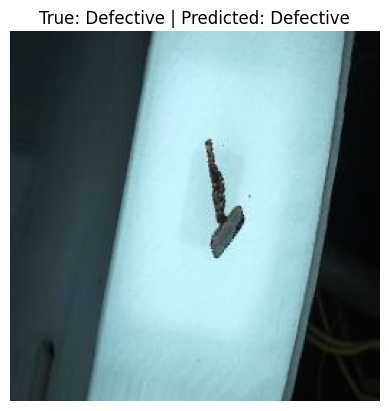

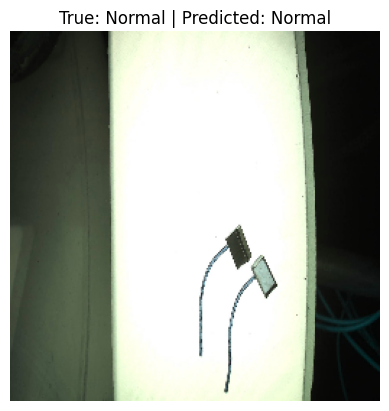

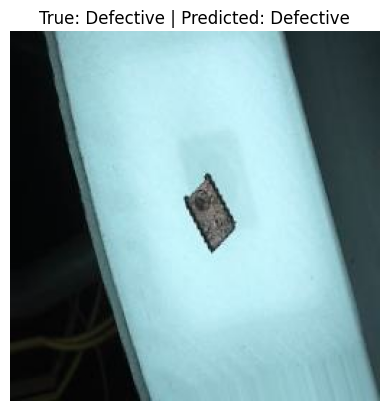

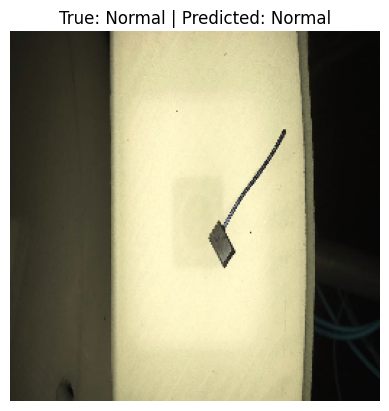

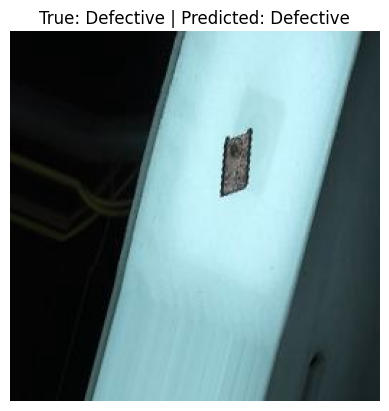

In [ ]:
import numpy as np
import os
import zipfile
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Paths to the ZIP folders
normal_data_zip = '/content/data (2).zip'  # Path to zip file for normal carbon brushes
defect_data_zip = '/content/carbon brush with defect.zip'  # Path to zip file for defective carbon brushes

# Temporary directories to extract the zip contents
normal_data_dir = 'normal_data_extracted'
defect_data_dir = 'defect_data_extracted'

# 1. Unzip the folders
def unzip_folder(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping normal and defective brush datasets
unzip_folder(normal_data_zip, normal_data_dir)
unzip_folder(defect_data_zip, defect_data_dir)

# 2. Preprocessing: Load and preprocess images
def load_images_from_folder(folder, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    labels = []
    for root, _, files in os.walk(folder):
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in color
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))  # Resize to standard dimensions
                img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                if 'defect' in file:  # Assuming defective files have 'defect' in their name
                    labels.append(1)  # Label defective images as 1
                else:
                    labels.append(0)  # Label normal images as 0
    return np.array(images), np.array(labels)

# Load and preprocess the images and labels
normal_images, normal_labels = load_images_from_folder(normal_data_dir)
defect_images, defect_labels = load_images_from_folder(defect_data_dir)

# Combine normal and defective images into one dataset
X = np.concatenate([normal_images, defect_images])
y = np.concatenate([normal_labels, defect_labels])

# 3. Augment defective images to balance the dataset
num_defective_images = defect_images.shape[0]
num_normal_images = normal_images.shape[0]

# Calculate how many defective images need to be generated
num_to_generate = num_normal_images - num_defective_images

# Image augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create directory to save augmented images if not exists
augmented_dir = 'augmented_defects'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

augmented_images = []
for i in range(num_to_generate):
    img = defect_images[i % num_defective_images]  # Loop through defect images if we need to generate more than available
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Generate augmented images (in memory) and save them
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='defect', save_format='jpeg'):
        i += 1
        if i > 2:  # Generate 5 augmentations per image
            break

# 4. Re-load augmented images into dataset
augmented_defect_images = []
augmented_defect_labels = []
for root, _, files in os.walk(augmented_dir):
    for file in files:
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize to standard dimensions
            img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
            augmented_defect_images.append(img)
            augmented_defect_labels.append(1)  # Label as defect

# Combine original and augmented defect images with normal images
X = np.concatenate([normal_images, defect_images, np.array(augmented_defect_images)])
y = np.concatenate([normal_labels, defect_labels, np.array(augmented_defect_labels)])

# Define the Vision Transformer (ViT) model
def create_vit_model(img_height, img_width, num_classes=2, patch_size=16, num_patches=256):
    input_shape = (img_height, img_width, 3)
    inputs = layers.Input(shape=input_shape)

    # Split the image into patches
    patches = layers.Conv2D(filters=768, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((num_patches, -1))(patches)

    # Positional embeddings
    pos_emb = tf.Variable(tf.random.normal([1, num_patches, 768]))
    x = patches + pos_emb

    # Transformer encoder layers
    for _ in range(4):  # Number of encoder layers
        # Multi-head attention block
        x1 = layers.LayerNormalization()(x)
        attn_output = layers.MultiHeadAttention(num_heads=12, key_dim=64)(x1, x1)
        x = x + attn_output  # Residual connection

        # MLP block
        x2 = layers.LayerNormalization()(x)
        mlp_output = layers.Dense(3072, activation='gelu')(x2)
        mlp_output = layers.Dense(768)(mlp_output)
        x = x + mlp_output  # Residual connection

    # Classification head
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model
vit_model = create_vit_model(IMG_HEIGHT, IMG_WIDTH)
vit_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = vit_model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), batch_size=32)
# Predict and visualize results
def visualize_predictions(model, X, y, num_samples=5):
    predictions = model.predict(X)
    predicted_labels = np.argmax(predictions, axis=1)

    # Visualize the samples and their predicted labels
    for i in range(num_samples):
        plt.imshow(X[i])
        plt.title(f"True: {'Defective' if y[i] == 1 else 'Normal'} | Predicted: {'Defective' if predicted_labels[i] == 1 else 'Normal'}")
        plt.axis('off')
        plt.show()

# Visualize predictions on a few validation samples
visualize_predictions(vit_model, X_val, y_val)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict labels on the validation set
y_pred = vit_model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_labels)
precision = precision_score(y_val, y_pred_labels)
recall = recall_score(y_val, y_pred_labels)
f1 = f1_score(y_val, y_pred_labels)
conf_matrix = confusion_matrix(y_val, y_pred_labels)

# Print metrics in the desired format
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 12s/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[ 81   0]
 [  0 129]]
